# IMPORT LIBRARY YANG DI PERLUKAN

In [1]:
import numpy as np 
import pandas as pd 
import os
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from PIL import Image

## MENGAMBIL DATASET DARI LEMON_DATASET

In [2]:
root="lemon_dataset/"

## MELIHAT DATA YANG ADA DI DALAM

In [3]:
kelass=os.listdir(root)
kelass

['bad_quality', 'empty_background', 'good_quality']

## MEMASUKKAN DATA YANG ADA DI FOLDER

In [4]:
gambar=[]
jenis=[]
for kelas in kelass:
    directory = root + kelas + '/'
    for Gambar in os.listdir(directory):
        gambar.append(directory + Gambar)
        jenis.append(kelas)

In [5]:
gambar=pd.Series(gambar, name="Gambar")
jenis=pd.Series(jenis, name="Jenis")

In [6]:
data=pd.concat([gambar, jenis], axis=1)
data.head()

,Gambar,Jenis
0,lemon_dataset/bad_quality/bad_quality_0.jpg,bad_quality
1,lemon_dataset/bad_quality/bad_quality_1.jpg,bad_quality
2,lemon_dataset/bad_quality/bad_quality_10.jpg,bad_quality
3,lemon_dataset/bad_quality/bad_quality_100.jpg,bad_quality
4,lemon_dataset/bad_quality/bad_quality_101.jpg,bad_quality


In [7]:
data=data.sample(frac=1).reset_index(drop = True)
data.head()

,Gambar,Jenis
0,lemon_dataset/bad_quality/bad_quality_687.jpg,bad_quality
1,lemon_dataset/bad_quality/bad_quality_90.jpg,bad_quality
2,lemon_dataset/good_quality/good_quality_820.jpg,good_quality
3,lemon_dataset/good_quality/good_quality_817.jpg,good_quality
4,lemon_dataset/bad_quality/bad_quality_833.jpg,bad_quality


## MELIHAT GAMBAR YANG ADA DI DALAM DATA GAMBAR

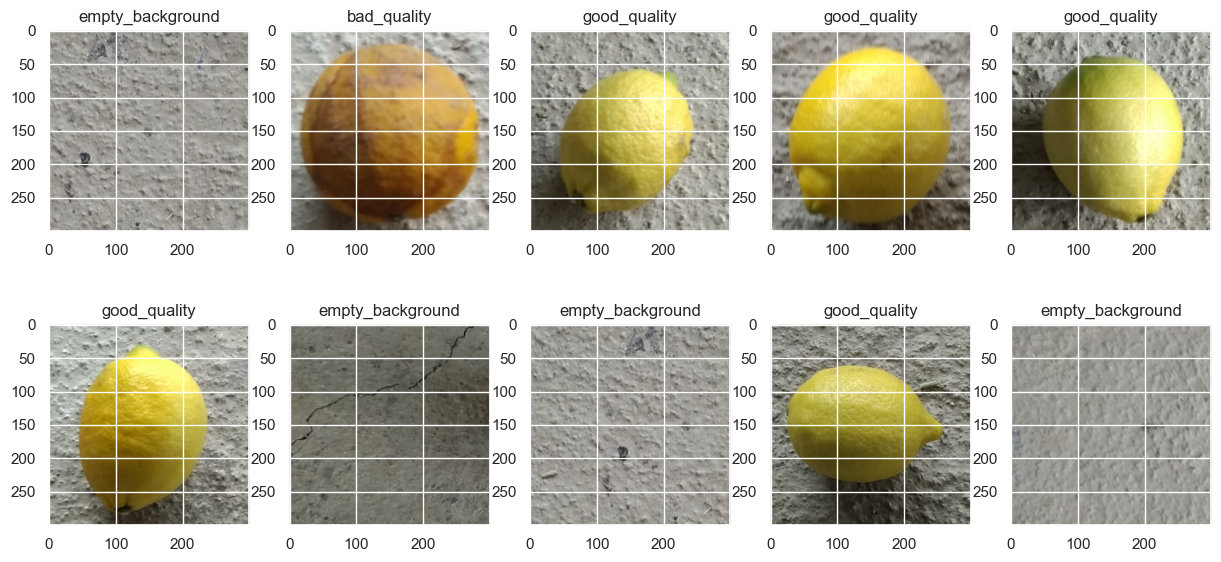

In [8]:
fig, axes = plt.subplots(2, 5, figsize=(15, 7))

for ax in axes.flat:
    i=np.random.randint(0, data.shape[0])
    ax.imshow(Image.open(data.loc[i, "Gambar"]))
    ax.set_title(data.Jenis[i])
    
    
plt.show()

In [9]:
from sklearn.model_selection import train_test_split

## dataset split: 85% for train, 15% for val

In [10]:
train, val =train_test_split(data, train_size=0.85, shuffle=True, random_state=32)

In [11]:
print(train.shape)
print(val.shape)

(2148, 2)
(380, 2)


## IMPORT LIBRARY KERAS DAN IMAGE

In [12]:
import keras

In [13]:
from keras.preprocessing import image

## IMAGE DATA GENERATOR

In [14]:
#image augmentation
train_generator = image.ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2, 
    zoom_range=0.2, 
    validation_split=0.2
)

In [15]:
train_images = train_generator.flow_from_dataframe(
    dataframe=train,
    x_col='Gambar',
    y_col='Jenis',
    target_size=(150, 150),
    color_mode='rgb',
    kelass_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=22,
    subset='training'
)

Found 1719 validated image filenames belonging to 3 classes.


In [16]:
val_images = train_generator.flow_from_dataframe(
    dataframe=train,
    x_col='Gambar',
    y_col='Jenis',
    target_size=(150, 150),
    color_mode='rgb',
    kelass_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=22,
    subset='validation'
)

Found 429 validated image filenames belonging to 3 classes.


## import library untuk CNN

In [17]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten, BatchNormalization
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, Callback
from keras.optimizers import gradient_descent_v2
from keras.optimizer_v2.adam import Adam as Adam
# from keras.optimizers import SGD

In [18]:
model=Sequential()

In [19]:
model.add(Conv2D(filters=16, kernel_size=(3,3), activation='relu', input_shape=(150,150,3)))
model.add(MaxPooling2D(pool_size=(2,2)))

In [20]:
model.add(BatchNormalization())
model.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(filters=64,kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

In [21]:
model.add(Flatten())
model.add(Dropout(0.2))
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(128, activation='relu'))
model.add(Dense(3, activation='softmax'))

In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 16)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 74, 74, 16)        64        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 64)        0

In [23]:
optimizer = Adam()
model.compile(optimizer=optimizer,loss='categorical_crossentropy',metrics=['acc', 'mse'])

In [24]:
early_stop = EarlyStopping(monitor='val_loss', patience=8, verbose=1, min_delta=1e-4)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4, verbose=1, min_delta=1e-4) 
callbacks_list = [early_stop, reduce_lr]

## model fitting

In [25]:
history = model.fit(train_images, validation_data=val_images, epochs=15, callbacks=callbacks_list)

Epoch 1/15
54/54 [==============================] - 13s 195ms/step - loss: 0.6421 - acc: 0.7213 - mse: 0.1247 - val_loss: 0.8824 - val_acc: 0.5152 - val_mse: 0.1802
Epoch 2/15
54/54 [==============================] - 10s 187ms/step - loss: 0.2587 - acc: 0.9081 - mse: 0.0477 - val_loss: 0.6594 - val_acc: 0.6760 - val_mse: 0.1384
Epoch 3/15
54/54 [==============================] - 10s 185ms/step - loss: 0.1649 - acc: 0.9383 - mse: 0.0316 - val_loss: 0.6537 - val_acc: 0.7249 - val_mse: 0.1348
Epoch 4/15
54/54 [==============================] - 10s 182ms/step - loss: 0.1099 - acc: 0.9616 - mse: 0.0200 - val_loss: 0.2549 - val_acc: 0.9021 - val_mse: 0.0480
Epoch 5/15
54/54 [==============================] - 10s 186ms/step - loss: 0.1245 - acc: 0.9663 - mse: 0.0205 - val_loss: 0.2875 - val_acc: 0.8741 - val_mse: 0.0598
Epoch 6/15
54/54 [==============================] - 10s 187ms/step - loss: 0.1480 - acc: 0.9517 - mse: 0.0260 - val_loss: 0.2215 - val_acc: 0.9114 - val_mse: 0.0432
Epoch 7/15

## accuracy and mse

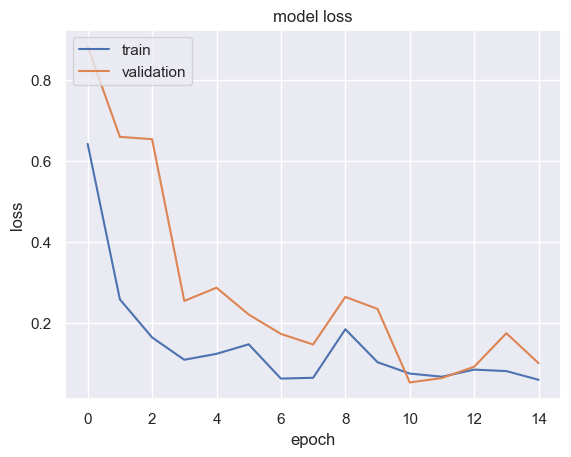

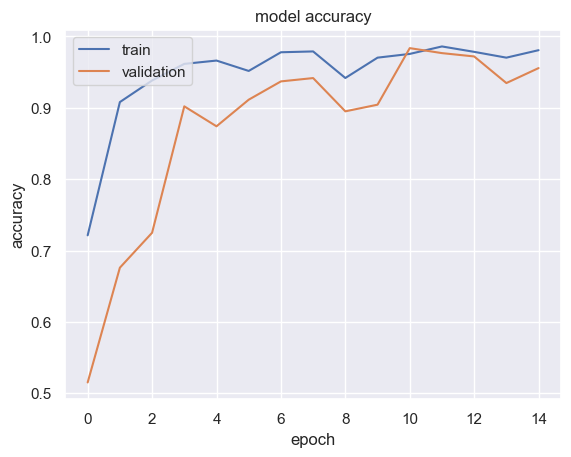

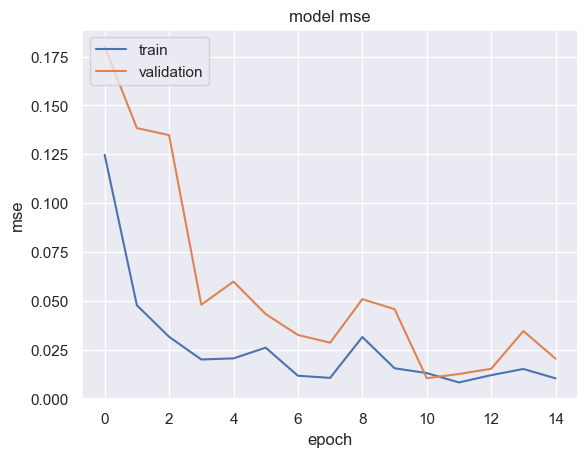

In [26]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.legend(['train', 'validation'], loc='upper left')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

plt.figure()
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

plt.figure()
plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])
plt.title('model mse')
plt.ylabel('mse')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()